### IMPORTING LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import tensorflow
import glob
import tqdm
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
%matplotlib inline

In [2]:
train_normal = glob.glob('../input/labeled-chest-xray-images/chest_xray/train/NORMAL/*.jpeg')
a = len(train_normal)

In [3]:
train_pneumonia = glob.glob('../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/*.jpeg')
b = len(train_pneumonia)

In [4]:
# Total training images

print("Total nos. of training images are: {}".format(a + b))

Total nos. of training images are: 5232


In [5]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   validation_split = 0.2)
valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)
test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [6]:
train_dataset = train_datagen.flow_from_directory(directory = '../input/labeled-chest-xray-images/chest_xray/train',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  subset = 'training',
                                                  batch_size = 64)

Found 4187 images belonging to 2 classes.


In [7]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/labeled-chest-xray-images/chest_xray/train',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 1045 images belonging to 2 classes.


In [8]:
# Checking Indices

train_dataset.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [9]:
len(train_dataset)

66

100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


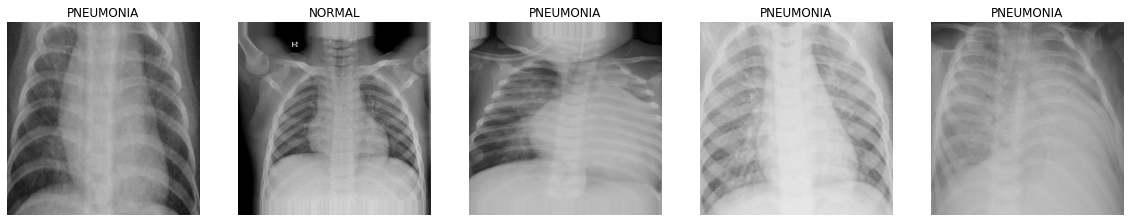

In [10]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))
for i in tqdm(range(0, 5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(64)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    label = train_dataset[rand1][1][rand2]
    if label == 1:
        ax[i].set_title('PNEUMONIA')
    else:
        ax[i].set_title('NORMAL')

In [11]:
# Defining Model

base_model = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

58892288/58889256 [==============================] - 3s 0us/step


In [12]:
# Freezing Layers 

for layer in base_model.layers:
    layer.trainable=False

In [13]:
# Summary

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
# Defining Layers

model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [15]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0

In [16]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [17]:
filepath = './best_weights.h5'
earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 3,
                              verbose = 1)
checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)
callback_list = [earlystopping, checkpoint]

In [18]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10
66/66 [==============================] - ETA: 0s - loss: 0.2465 - auc: 0.9611
Epoch 00001: val_auc improved from -inf to 0.97885, saving model to ./best_weights.h5
66/66 [==============================] - 119s 2s/step - loss: 0.2465 - auc: 0.9611 - val_loss: 0.1822 - val_auc: 0.9788
Epoch 2/10
66/66 [==============================] - ETA: 0s - loss: 0.1474 - auc: 0.9825
Epoch 00002: val_auc improved from 0.97885 to 0.98920, saving model to ./best_weights.h5
66/66 [==============================] - 95s 1s/step - loss: 0.1474 - auc: 0.9825 - val_loss: 0.1514 - val_auc: 0.9892
Epoch 3/10
66/66 [==============================] - ETA: 0s - loss: 0.1177 - auc: 0.9869
Epoch 00003: val_auc improved from 0.98920 to 0.99120, saving model to ./best_weights.h5
66/66 [==============================] - 96s 1s/step - loss: 0.1177 - auc: 0.9869 - val_loss: 0.1130 - val_auc: 0.9912
Epoch 4/10
66/66 [==============================] - ETA: 0s - loss: 0.1227 - auc: 0.9872
Epoch 00004: val_auc i

### MODEL EVALUATION

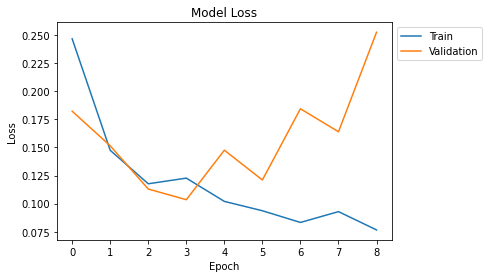

In [19]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

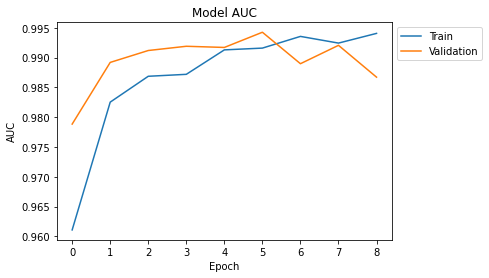

In [20]:
# Summarize models auc

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [21]:
# Test Data 

test_dataset = test_datagen.flow_from_directory(directory = '../input/labeled-chest-xray-images/chest_xray/test',
                                                target_size = (224,224),
                                                class_mode = 'binary',
                                                batch_size = 64)

Found 624 images belonging to 2 classes.


In [23]:
class_dict = train_dataset.class_indices
print("Class indices:", class_dict)

Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


In [26]:
import pickle
import os

In [27]:
class_indices_path = "/kaggle/working/pneumonia_class_indices.pkl"
os.makedirs(os.path.dirname(class_indices_path), exist_ok=True)
with open(class_indices_path, "wb") as f:
    pickle.dump(class_dict, f)
print(f"Class indices saved to {class_indices_path}")

Class indices saved to /kaggle/working/pneumonia_class_indices.pkl


In [28]:
model.evaluate(test_dataset)

10/10 [==============================] - 9s 929ms/step - loss: 0.2201 - auc: 0.9789


[0.22012189030647278, 0.9789228439331055]

The X-RAY belongs to NORMAL person


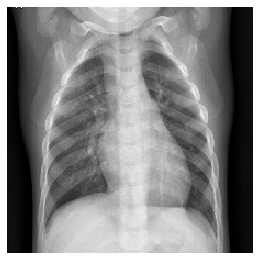

In [29]:
# Test Case 1: NORMAL

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../input/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-1212407-0001.jpeg', target_size=(224,224))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_proba(img)

if answer[0][0] > 0.5:
    print("The X-Ray belongs to PNEUMONIA person")
else:
    print("The X-RAY belongs to NORMAL person")

The X-RAY belongs to NORMAL person


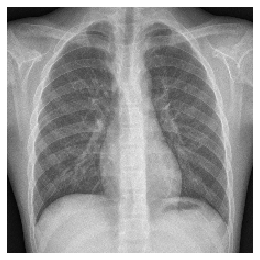

In [30]:
# Test Case 2: PNEUMONIA

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/kaggle/input/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-1160949-0001.jpeg', target_size=(224,224))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_proba(img)

if answer[0][0] > 0.5:
    print("The X-Ray belongs to PNEUMONIA person")
else:
    print("The X-RAY belongs to NORMAL person")

### CONCLUSION


In [31]:
import tensorflow as tf
import pickle
model.save("pneumonia_model.h5")

In [28]:
class_indices = {'NORMAL': 0, 'PNEUMONIA': 1}

# Save class indices in a pickle file
with open("class_indices.pkl", "wb") as f:
    pickle.dump(class_indices, f)


In [32]:
model.save("pneumonia_model.keras")

> `1. We where able to successfully classify the images with 99.4% accuracy on training dataset.`

> `2. We acheived 99.52% accuracy on validation data and 98.3% accuracy on test dataset.`